# Applying Neural Network to Yield Curve

## Introduction
Neural networks (NN) and other deep learning are currently all the rage - however probably more widespread than their apparent applications seems to be the lack of knowledge about them. For many they are black boxes that hold the keys to all answers.

In fact (at least the simple ones) are no-more than large scale applications of linear algebra, with the weights of the matrices optimised to best fit data. Recent advances in compute power have finally made them accessible. Their applications in image recognition are well publicised, however they can be used almost anywhere you have a classification problem.

I attempt to use a simple neural network on the yield curve in part to show how to implement NN and hopefully demystify them. The other advatage of this approach as well is that it is non-parametrised - this is useful as too often our approaches are clouded by preconceived notions and our own biases. In this way we can hope to see that NN are not the end of humans, but rather the start of a synergy between humans and the insights provided by machines - indeed many commented that AlphaGo's unexpected moves have given even experienced players new food for thought and strategies. (This is also a great video on "insight" machine learning can give: https://youtu.be/GdTBqBnqhaQ).

## Basics
We apply a simple dense neural network to treasury yield data and see if we can decompose the data into factors. The benefits here are that we can use our input as our targets as well - the method here is not too dissimilar to a simple autoencoder.

We obtain the data from here:
https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yieldAll


In [1]:
# Import the some modules
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
yc_data = pd.read_csv("us_yc.csv")
yc_data["Date"] = pd.to_datetime(yc_data["Date"], infer_datetime_format=True)

# Clean the data - issues:
# We lose a patch of 30y as explained
# After that drop NA
yc_data_cleaned = yc_data.drop(columns=["30 Yr"])
yc_data_cleaned.dropna(axis=0, how="any", inplace=True)
# Set index to date
yc_data_cleaned.index = yc_data_cleaned["Date"]
yc_data_cleaned.drop(columns=["Date"], inplace=True)
# Check our data looks as expected
yc_data_cleaned.head()

,1 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr
Date,,,,,,,,,,
2001-07-31,3.67,3.54,3.47,3.53,3.79,4.06,4.57,4.86,5.07,5.61
2001-08-01,3.65,3.53,3.47,3.56,3.83,4.09,4.62,4.90,5.11,5.63
2001-08-02,3.65,3.53,3.46,3.57,3.89,4.17,4.69,4.97,5.17,5.68
2001-08-03,3.63,3.52,3.47,3.57,3.91,4.22,4.72,4.99,5.20,5.70
2001-08-06,3.62,3.52,3.47,3.56,3.88,4.17,4.71,4.99,5.19,5.70


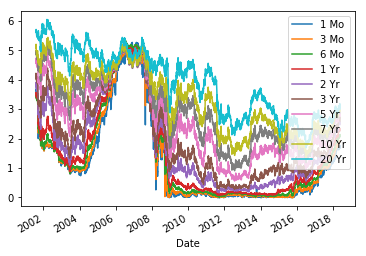

In [3]:
yc_data_cleaned.plot()

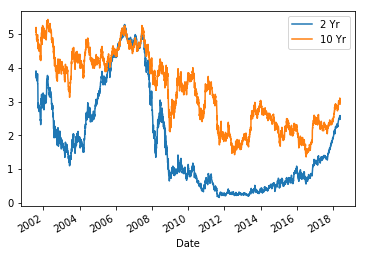

In [4]:
# A tad messy to let's just plot 2y and 10y
yc_data_cleaned.loc[:, ["2 Yr", "10 Yr"]].plot()

In [5]:
len(yc_data_cleaned)

4205

In [6]:
# Create some training, validation and test sets
train_yc = yc_data_cleaned[:2400]
valid_yc = yc_data_cleaned[2400:3000]
test_yc = yc_data_cleaned[3000:]
print train_yc.head()
print valid_yc.head()
print test_yc.head()

            1 Mo  3 Mo  6 Mo  1 Yr  2 Yr  3 Yr  5 Yr  7 Yr  10 Yr  20 Yr
Date                                                                    
2001-07-31  3.67  3.54  3.47  3.53  3.79  4.06  4.57  4.86   5.07   5.61
2001-08-01  3.65  3.53  3.47  3.56  3.83  4.09  4.62  4.90   5.11   5.63
2001-08-02  3.65  3.53  3.46  3.57  3.89  4.17  4.69  4.97   5.17   5.68
2001-08-03  3.63  3.52  3.47  3.57  3.91  4.22  4.72  4.99   5.20   5.70
2001-08-06  3.62  3.52  3.47  3.56  3.88  4.17  4.71  4.99   5.19   5.70
            1 Mo  3 Mo  6 Mo  1 Yr  2 Yr  3 Yr  5 Yr  7 Yr  10 Yr  20 Yr
Date                                                                    
2011-03-11  0.04  0.08  0.13  0.24  0.64  1.12  2.06  2.76   3.40   4.29
2011-03-14  0.05  0.09  0.14  0.22  0.61  1.07  2.00  2.70   3.36   4.25
2011-03-15  0.07  0.10  0.14  0.23  0.63  1.08  2.00  2.68   3.33   4.21
2011-03-16  0.06  0.10  0.14  0.21  0.58  0.98  1.87  2.56   3.22   4.11
2011-03-17  0.06  0.08  0.14  0.24  0.60  1.02  1.9

In [8]:
print train_yc.shape[1]

10


In [10]:
# Build our NN
from keras.layers import Dense
from keras.models import Sequential

input_dim = train_yc.shape[1]
hidden_nodes = 5 # This the number of factors

# Define the model
model = Sequential()
model.add(Dense(hidden_nodes, activation="relu", input_shape=(input_dim, )))
model.add(Dense(input_dim, activation=None))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                60        
Total params: 115
Trainable params: 115
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Here we see we have a relatively small NN
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.optimised.hdf5', 
                               verbose=1, save_best_only=True)

# Here we do some last minute model tidy up
epochs = 100
# Convert data to numpy arrays
train_yc = train_yc.values
valid_yc = valid_yc.values
test_yc = test_yc.values

In [17]:
batch_n = 2000
model.fit(train_yc, train_yc, 
         validation_data=(valid_yc, valid_yc),
         epochs=epochs, batch_size=batch_n, callbacks=[checkpointer], verbose=2)

Train on 2400 samples, validate on 600 samples
Epoch 1/100
 - 0s - loss: 275.8676 - acc: 8.3333e-04 - val_loss: 98.9858 - val_acc: 0.0000e+00

Epoch 00001: val_loss did not improve from 32.10231
Epoch 2/100
 - 0s - loss: 284.2734 - acc: 8.3333e-04 - val_loss: 98.3210 - val_acc: 0.0000e+00

Epoch 00002: val_loss did not improve from 32.10231
Epoch 3/100
 - 0s - loss: 280.8937 - acc: 8.3333e-04 - val_loss: 98.9392 - val_acc: 0.0000e+00

Epoch 00003: val_loss did not improve from 32.10231
Epoch 4/100
 - 0s - loss: 282.0997 - acc: 8.3333e-04 - val_loss: 97.1502 - val_acc: 0.0000e+00

Epoch 00004: val_loss did not improve from 32.10231
Epoch 5/100
 - 0s - loss: 272.3065 - acc: 8.3333e-04 - val_loss: 72.3627 - val_acc: 0.0000e+00

Epoch 00005: val_loss did not improve from 32.10231
Epoch 6/100
 - 0s - loss: 246.4535 - acc: 8.3333e-04 - val_loss: 91.8299 - val_acc: 0.0000e+00

Epoch 00006: val_loss did not improve from 32.10231
Epoch 7/100
 - 0s - loss: 257.1220 - acc: 8.3333e-04 - val_loss: 

In [18]:
# Load the best weights
model.load_weights("saved_models/weights.optimised.hdf5")

In [19]:
model.get_weights()

[array([[ 0.19569415, -0.03775368, -0.27069426, -0.5738889 ,  0.45608443],
        [-0.51492506, -0.53485626, -0.15589231,  0.18278104, -0.07023108],
        [ 0.18559432, -0.34407133, -0.41611379,  0.34202752, -0.62441409],
        [-0.02542198,  0.61873043, -0.1659258 ,  0.15548617, -0.21953481],
        [ 0.06611383,  0.13577448, -0.39797539,  0.24431342,  0.52209038],
        [-0.07309157,  0.52410477, -0.60432792, -0.31737217, -0.48264199],
        [-0.20967516,  0.3478412 , -0.58430088,  0.1298728 , -0.45045906],
        [ 0.11426848, -0.08839346, -0.4461658 ,  0.42285925, -0.47466433],
        [-0.35560393,  0.45486921, -0.62383854,  0.01725834, -0.50492167],
        [-0.10873961, -0.48791647,  0.29814154,  0.43749443,  0.02789932]], dtype=float32),
 array([ 0.        ,  0.00997835,  0.        , -0.01623316,  0.        ], dtype=float32),
 array([[-0.38491899, -0.49147433,  0.58988208, -0.30756524, -0.06203979,
          0.31837076, -0.33252022,  0.13962471, -0.56981999,  0.16996

In [22]:
model.get_weights()[0]

array([[ 0.19569415, -0.03775368, -0.27069426, -0.5738889 ,  0.45608443],
       [-0.51492506, -0.53485626, -0.15589231,  0.18278104, -0.07023108],
       [ 0.18559432, -0.34407133, -0.41611379,  0.34202752, -0.62441409],
       [-0.02542198,  0.61873043, -0.1659258 ,  0.15548617, -0.21953481],
       [ 0.06611383,  0.13577448, -0.39797539,  0.24431342,  0.52209038],
       [-0.07309157,  0.52410477, -0.60432792, -0.31737217, -0.48264199],
       [-0.20967516,  0.3478412 , -0.58430088,  0.1298728 , -0.45045906],
       [ 0.11426848, -0.08839346, -0.4461658 ,  0.42285925, -0.47466433],
       [-0.35560393,  0.45486921, -0.62383854,  0.01725834, -0.50492167],
       [-0.10873961, -0.48791647,  0.29814154,  0.43749443,  0.02789932]], dtype=float32)